# This is a usage example of simpleCPP_test.py in pyhddmjags

It follows a script in the [pyhddmjags](https://github.com/mdnunez/pyhddmjags) repository by Michael D. Nunez

This script will run nicely on [Google Colab](https://colab.research.google.com/) without needing to install anything yourself.

If you wish to install things locally, please avoid running the first part of this script and instead see [the installation instructions](https://github.com/mdnunez/pyhddmjags/blob/master/jags_wiener_ubuntu.md). Note that installing JAGS-WIENER on Windows with the latest version of JAGS is difficult.



The first steps install JAGS, JAGS-WIENER, and pyjags directly from Python onto Ubuntu 18.04 hosted by Google.
See the [installation steps](https://github.com/mdnunez/pyhddmjags/blob/master/jags_wiener_ubuntu.md) for your own Ubuntu, Mac, on Windows Linux Subsystem installation.



In [3]:
!lsb_release -a
!pwd

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic
/content


In [5]:
!sudo apt-get update
!sudo apt-get install jags

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency t

In [7]:
!which jags

/usr/bin/jags


In [15]:
import os
os.system("TEMP_DEB='$(mktemp)' ")
os.system("wget -O '$TEMP_DEB' 'https://launchpad.net/~cidlab/+archive/ubuntu/jwm/+files/jags-wiener-module_1.1-5_amd64.deb'")
os.system("sudo dpkg -i '$TEMP_DEB'")
os.system("rm -f '$TEMP_DEB'")

0

In [17]:
!jags

Welcome to JAGS 4.3.0 on Mon Aug  1 13:44:26 2022
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. load wiener
Loading module: wiener: ok
. load dic
Loading module: dic: ok
. exit


In [18]:
!pip install pyjags

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 184 kB 5.3 MB/s 
  Created wheel for pyjags: filename=pyjags-1.3.8-cp37-cp37m-linux_x86_64.whl size=1085723 sha256=908efb48e3345ec41935800b123a23d427eb886c24574b32e2a1f28f28c149b3
  Stored in directory: /root/.cache/pip/wheels/fe/d4/3c/db6da791fe067bbafa86132df6b3744bd8e2950b871c538ffe
Successfully built pyjags


JAGS, JAGS-WIENER, and pyjags are now installed!

# Now let's run [simpleCPP_test.py](https://github.com/mdnunez/pyhddmjags/blob/master/simpleCPP_test.py) from the [pyhddmjags](https://github.com/mdnunez/pyhddmjags) repository:

First let's import the necessary modules

In [24]:
import numpy as np
import warnings
import pyjags
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
from scipy import stats

Let's make some definitions that we need later.

In [40]:
# Simulate diffusion models quickly with intrinsic trial-to-trial variability in parameters
def simulratcliff(N=100,Alpha=1,Tau=.4,Nu=1,Beta=.5,rangeTau=0,rangeBeta=0,Eta=.3,Varsigma=1):
    """
    SIMULRATCLIFF  Generates data according to a drift diffusion model with optional trial-to-trial variability


    Reference:
    Tuerlinckx, F., Maris, E.,
    Ratcliff, R., & De Boeck, P. (2001). A comparison of four methods for
    simulating the diffusion process. Behavior Research Methods,
    Instruments, & Computers, 33, 443-456.

    Parameters
    ----------
    N: a integer denoting the size of the output vector
    (defaults to 100 experimental trials)

    Alpha: the mean boundary separation across trials  in evidence units
    (defaults to 1 evidence unit)

    Tau: the mean non-decision time across trials in seconds
    (defaults to .4 seconds)

    Nu: the mean drift rate across trials in evidence units per second
    (defaults to 1 evidence units per second, restricted to -5 to 5 units)

    Beta: the initial bias in the evidence process for choice A as a proportion of boundary Alpha
    (defaults to .5 or 50% of total evidence units given by Alpha)

    rangeTau: Non-decision time across trials is generated from a uniform
    distribution of Tau - rangeTau/2 to  Tau + rangeTau/2 across trials
    (defaults to 0 seconds)

    rangeZeta: Bias across trials is generated from a uniform distribution
    of Zeta - rangeZeta/2 to Zeta + rangeZeta/2 across trials
    (defaults to 0 evidence units)

    Eta: Standard deviation of the drift rate across trials
    (defaults to 3 evidence units per second, restricted to less than 3 evidence units)

    Varsigma: The diffusion coefficient, the standard deviation of the
    evidence accumulation process within one trial. It is recommended that
    this parameter be kept fixed unless you have reason to explore this parameter
    (defaults to 1 evidence unit per second)

    Returns
    -------
    Numpy array with reaction times (in seconds) multiplied by the response vector
    such that negative reaction times encode response B and positive reaction times
    encode response A 
    
    
    Converted from simuldiff.m MATLAB script by Joachim Vandekerckhove
    See also http://ppw.kuleuven.be/okp/dmatoolbox.
    """

    if (Nu < -5) or (Nu > 5):
        Nu = np.sign(Nu)*5
        warnings.warn('Nu is not in the range [-5 5], bounding drift rate to %.1f...' % (Nu))

    if (Eta > 3):
        warning.warn('Standard deviation of drift rate is out of bounds, bounding drift rate to 3')
        eta = 3

    if (Eta == 0):
        Eta = 1e-16

    #Initialize output vectors
    result = np.zeros(N)
    T = np.zeros(N)
    XX = np.zeros(N)

    #Called sigma in 2001 paper
    D = np.power(Varsigma,2)/2

    #Program specifications
    eps = 2.220446049250313e-16 #precision from 1.0 to next double-precision number
    delta=eps

    for n in range(0,N):
        r1 = np.random.normal()
        mu = Nu + r1*Eta
        bb = Beta - rangeBeta/2 + rangeBeta*np.random.uniform()
        zz = bb*Alpha
        finish = 0
        totaltime = 0
        startpos = 0
        Aupper = Alpha - zz
        Alower = -zz
        radius = np.min(np.array([np.abs(Aupper), np.abs(Alower)]))
        while (finish==0):
            lambda_ = 0.25*np.power(mu,2)/D + 0.25*D*np.power(np.pi,2)/np.power(radius,2)
            # eq. formula (13) in 2001 paper with D = sigma^2/2 and radius = Alpha/2
            F = D*np.pi/(radius*mu)
            F = np.power(F,2)/(1 + np.power(F,2) )
            # formula p447 in 2001 paper
            prob = np.exp(radius*mu/D)
            prob = prob/(1 + prob)
            dir_ = 2*(np.random.uniform() < prob) - 1
            l = -1
            s2 = 0
            while (s2>l):
                s2=np.random.uniform()
                s1=np.random.uniform()
                tnew=0
                told=0
                uu=0
                while (np.abs(tnew-told)>eps) or (uu==0):
                    told=tnew
                    uu=uu+1
                    tnew = told + (2*uu+1) * np.power(-1,uu) * np.power(s1,(F*np.power(2*uu+1,2)));
                    # infinite sum in formula (16) in BRMIC,2001
                l = 1 + np.power(s1,(-F)) * tnew;
            # rest of formula (16)
            t = np.abs(np.log(s1))/lambda_;
            # is the negative of t* in (14) in BRMIC,2001
            totaltime=totaltime+t
            dir_=startpos+dir_*radius
            ndt = Tau - rangeTau/2 + rangeTau*np.random.uniform()
            if ( (dir_ + delta) > Aupper):
                T[n]=ndt+totaltime
                XX[n]=1
                finish=1
            elif ( (dir_-delta) < Alower ):
                T[n]=ndt+totaltime
                XX[n]=-1
                finish=1
            else:
                startpos=dir_
                radius=np.min(np.abs([Aupper, Alower]-startpos))

    result = T*XX
    return result


def diagnostic(insamples):
    """
    Returns two versions of Rhat (measure of convergence, less is better with an approximate
    1.10 cutoff) and Neff, number of effective samples). Note that 'rhat' is more diagnostic than 'oldrhat' according to 
    Gelman et al. (2014).

    Reference for preferred Rhat calculation (split chains) and number of effective sample calculation: 
        Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A. & Rubin, D. B. (2014). 
        Bayesian data analysis (Third Edition). CRC Press:
        Boca Raton, FL

    Reference for original Rhat calculation:
        Gelman, A., Carlin, J., Stern, H., & Rubin D., (2004).
        Bayesian Data Analysis (Second Edition). Chapman & Hall/CRC:
        Boca Raton, FL.


    Parameters
    ----------
    insamples: dic
        Sampled values of monitored variables as a dictionary where keys
        are variable names and values are numpy arrays with shape:
        (dim_1, dim_n, iterations, chains). dim_1, ..., dim_n describe the
        shape of variable in JAGS model.

    Returns
    -------
    dict:
        rhat, oldrhat, neff, posterior mean, and posterior std for each variable. Prints maximum Rhat and minimum Neff across all variables
    """

    result = {}  # Initialize dictionary
    maxrhatsold = np.zeros((len(insamples.keys())), dtype=float)
    maxrhatsnew = np.zeros((len(insamples.keys())), dtype=float)
    minneff = np.ones((len(insamples.keys())), dtype=float)*np.inf
    allkeys ={} # Initialize dictionary
    keyindx = 0
    for key in insamples.keys():
        if key[0] != '_':
            result[key] = {}
            
            possamps = insamples[key]
            
            # Number of chains
            nchains = possamps.shape[-1]
            
            # Number of samples per chain
            nsamps = possamps.shape[-2]
            
            # Number of variables per key
            nvars = np.prod(possamps.shape[0:-2])
            
            # Reshape data
            allsamps = np.reshape(possamps, possamps.shape[:-2] + (nchains * nsamps,))

            # Reshape data to preduce R_hatnew
            possampsnew = np.empty(possamps.shape[:-2] + (int(nsamps/2), nchains * 2,))
            newc=0
            for c in range(nchains):
                possampsnew[...,newc] = np.take(np.take(possamps,np.arange(0,int(nsamps/2)),axis=-2),c,axis=-1)
                possampsnew[...,newc+1] = np.take(np.take(possamps,np.arange(int(nsamps/2),nsamps),axis=-2),c,axis=-1)
                newc += 2

            # Index of variables
            varindx = np.arange(nvars).reshape(possamps.shape[0:-2])
            
            # Reshape data
            alldata = np.reshape(possamps, (nvars, nsamps, nchains))
                    
            # Mean of each chain for rhat
            chainmeans = np.mean(possamps, axis=-2)
            # Mean of each chain for rhatnew
            chainmeansnew = np.mean(possampsnew, axis=-2)
            # Global mean of each parameter for rhat
            globalmean = np.mean(chainmeans, axis=-1)
            globalmeannew = np.mean(chainmeansnew, axis=-1)
            result[key]['mean'] = globalmean
            result[key]['std'] = np.std(allsamps, axis=-1)
            globalmeanext = np.expand_dims(
                globalmean, axis=-1)  # Expand the last dimension
            globalmeanext = np.repeat(
                globalmeanext, nchains, axis=-1)  # For differencing
            globalmeanextnew = np.expand_dims(
                globalmeannew, axis=-1)  # Expand the last dimension
            globalmeanextnew = np.repeat(
                globalmeanextnew, nchains*2, axis=-1)  # For differencing
            # Between-chain variance for rhat
            between = np.sum(np.square(chainmeans - globalmeanext),
                             axis=-1) * nsamps / (nchains - 1.)
            # Mean of the variances of each chain for rhat
            within = np.mean(np.var(possamps, axis=-2), axis=-1)
            # Total estimated variance for rhat
            totalestvar = (1. - (1. / nsamps)) * \
                within + (1. / nsamps) * between
            # Rhat (original Gelman-Rubin statistic)
            temprhat = np.sqrt(totalestvar / within)
            maxrhatsold[keyindx] = np.nanmax(temprhat) # Ignore NANs
            allkeys[keyindx] = key
            result[key]['oldrhat'] = temprhat
            # Between-chain variance for rhatnew
            betweennew = np.sum(np.square(chainmeansnew - globalmeanextnew),
                             axis=-1) * (nsamps/2) / ((nchains*2) - 1.)
            # Mean of the variances of each chain for rhatnew
            withinnew = np.mean(np.var(possampsnew, axis=-2), axis=-1)
            # Total estimated variance
            totalestvarnew = (1. - (1. / (nsamps/2))) * \
                withinnew + (1. / (nsamps/2)) * betweennew
            # Rhatnew (Gelman-Rubin statistic from Gelman et al., 2013)
            temprhatnew = np.sqrt(totalestvarnew / withinnew)
            maxrhatsnew[keyindx] = np.nanmax(temprhatnew) # Ignore NANs
            result[key]['rhat'] = temprhatnew
            # Number of effective samples from Gelman et al. (2013) 286-288
            neff = np.empty(possamps.shape[0:-2])
            for v in range(0, nvars):
                whereis = np.where(varindx == v)
                rho_hat = []
                rho_hat_even = 0
                rho_hat_odd = 0
                t = 2
                while ((t < nsamps - 2) & (float(rho_hat_even) + float(rho_hat_odd) >= 0)):
                    variogram_odd = np.mean(np.mean(np.power(alldata[v,(t-1):nsamps,:] - alldata[v,0:(nsamps-t+1),:],2),axis=0)) # above equation (11.7) in Gelman et al., 2013
                    rho_hat_odd = 1 - np.divide(variogram_odd, 2*totalestvar[whereis]) # Equation (11.7) in Gelman et al., 2013
                    rho_hat.append(rho_hat_odd)
                    variogram_even = np.mean(np.mean(np.power(alldata[v,t:nsamps,:] - alldata[v,0:(nsamps-t),:],2),axis=0)) # above equation (11.7) in Gelman et al., 2013
                    rho_hat_even = 1 - np.divide(variogram_even, 2*totalestvar[whereis]) # Equation (11.7) in Gelman et al., 2013
                    rho_hat.append(rho_hat_even)
                    t += 2
                rho_hat = np.asarray(rho_hat)
                neff[whereis] = np.divide(nchains*nsamps, 1 + 2*np.sum(rho_hat)) # Equation (11.8) in Gelman et al., 2013
            result[key]['neff'] = np.round(neff) 
            minneff[keyindx] = np.nanmin(np.round(neff))
            keyindx += 1

            # Geweke statistic?
    # print("Maximum old Rhat was %3.2f for variable %s" % (np.max(maxrhatsold),allkeys[np.argmax(maxrhatsold)]))
    maxrhatkey = allkeys[np.argmax(maxrhatsnew)]
    maxrhatindx = np.unravel_index( np.argmax(result[maxrhatkey]['rhat']) , result[maxrhatkey]['rhat'].shape)
    print("Maximum Rhat was %3.2f for variable %s at index %s" % (np.max(maxrhatsnew), maxrhatkey, maxrhatindx))
    minneffkey = allkeys[np.argmin(minneff)]
    minneffindx = np.unravel_index( np.argmin(result[minneffkey]['neff']) , result[minneffkey]['neff'].shape)
    print("Minimum number of effective samples was %d for variable %s at index %s" % (np.min(minneff), minneffkey, minneffindx))
    return result


def recovery(possamps, truevals):  # Parameter recovery plots
    """Plots true parameters versus 99% and 95% credible intervals of recovered
    parameters. Also plotted are the median (circles) and mean (stars) of the posterior
    distributions.

    Parameters
    ----------
    possamps : ndarray of posterior chains where the last dimension is the
    number of chains, the second to last dimension is the number of samples in
    each chain, all other dimensions must match the dimensions of truevals

    truevals : ndarray of true parameter values
    """

    # Number of chains
    nchains = possamps.shape[-1]

    # Number of samples per chain
    nsamps = possamps.shape[-2]

    # Number of variables to plot
    nvars = np.prod(possamps.shape[0:-2])

    # Reshape data
    alldata = np.reshape(possamps, (nvars, nchains, nsamps))
    alldata = np.reshape(alldata, (nvars, nchains * nsamps))
    truevals = np.reshape(truevals, (nvars))

    # Plot properties
    LineWidths = np.array([2, 5])
    teal = np.array([0, .7, .7])
    blue = np.array([0, 0, 1])
    orange = np.array([1, .3, 0])
    Colors = [teal, blue]

    for v in range(0, nvars):
        # Compute percentiles
        bounds = stats.scoreatpercentile(alldata[v, :], (.5, 2.5, 97.5, 99.5))
        for b in range(0, 2):
            # Plot credible intervals
            credint = np.ones(100) * truevals[v]
            y = np.linspace(bounds[b], bounds[-1 - b], 100)
            lines = plt.plot(credint, y)
            plt.setp(lines, color=Colors[b], linewidth=LineWidths[b])
            if b == 1:
                # Mark median
                mmedian = plt.plot(truevals[v], np.median(alldata[v, :]), 'o')
                plt.setp(mmedian, markersize=10, color=[0., 0., 0.])
                # Mark mean
                mmean = plt.plot(truevals[v], np.mean(alldata[v, :]), '*')
                plt.setp(mmean, markersize=10, color=teal)
    # Plot line y = x
    tempx = np.linspace(np.min(truevals), np.max(
        truevals), num=100)
    recoverline = plt.plot(tempx, tempx)
    plt.setp(recoverline, linewidth=3, color=orange)

def jellyfish(possamps):  # jellyfish plots
    """Plots posterior distributions of given posterior samples in a jellyfish
    plot. Jellyfish plots are posterior distributions (mirrored over their
    horizontal axes) with 99% and 95% credible intervals (currently plotted
    from the .5% and 99.5% & 2.5% and 97.5% percentiles respectively.
    Also plotted are the median and mean of the posterior distributions"

    Parameters
    ----------
    possamps : ndarray of posterior chains where the last dimension is
    the number of chains, the second to last dimension is the number of samples
    in each chain, all other dimensions describe the shape of the parameter
    """

    # Number of chains
    nchains = possamps.shape[-1]

    # Number of samples per chain
    nsamps = possamps.shape[-2]

    # Number of dimensions
    ndims = possamps.ndim - 2

    # Number of variables to plot
    nvars = np.prod(possamps.shape[0:-2])

    # Index of variables
    varindx = np.arange(nvars).reshape(possamps.shape[0:-2])

    # Reshape data
    alldata = np.reshape(possamps, (nvars, nchains, nsamps))
    alldata = np.reshape(alldata, (nvars, nchains * nsamps))

    # Plot properties
    LineWidths = np.array([2, 5])
    teal = np.array([0, .7, .7])
    blue = np.array([0, 0, 1])
    orange = np.array([1, .3, 0])
    Colors = [teal, blue]

    # Initialize ylabels list
    ylabels = ['']

    for v in range(0, nvars):
        # Create ylabel
        whereis = np.where(varindx == v)
        newlabel = ''
        for l in range(0, ndims):
            newlabel = newlabel + ('_%i' % whereis[l][0])

        ylabels.append(newlabel)

        # Compute posterior density curves
        kde = stats.gaussian_kde(alldata[v, :])
        bounds = stats.scoreatpercentile(alldata[v, :], (.5, 2.5, 97.5, 99.5))
        for b in range(0, 2):
            # Bound by .5th percentile and 99.5th percentile
            x = np.linspace(bounds[b], bounds[-1 - b], 100)
            p = kde(x)

            # Scale distributions down
            maxp = np.max(p)

            # Plot jellyfish
            upper = .25 * p / maxp + v + 1
            lower = -.25 * p / maxp + v + 1
            lines = plt.plot(x, upper, x, lower)
            plt.setp(lines, color=Colors[b], linewidth=LineWidths[b])
            if b == 1:
                # Mark mode
                wheremaxp = np.argmax(p)
                mmode = plt.plot(np.array([1., 1.]) * x[wheremaxp],
                                 np.array([lower[wheremaxp], upper[wheremaxp]]))
                plt.setp(mmode, linewidth=3, color=orange)
                # Mark median
                mmedian = plt.plot(np.median(alldata[v, :]), v + 1, 'ko')
                plt.setp(mmedian, markersize=10, color=[0., 0., 0.])
                # Mark mean
                mmean = plt.plot(np.mean(alldata[v, :]), v + 1, '*')
                plt.setp(mmean, markersize=10, color=teal)

    # Display plot
    plt.setp(plt.gca(), yticklabels=ylabels, yticks=np.arange(0, nvars + 1))



Let's create some folders to save some data and figures

In [35]:
os.system('mkdir data')
os.system('mkdir jagscode')
os.system('mkdir modelfits')
os.system('mkdir figures')

0

Now let's run the simulation of the model.

In [29]:
### Simulations ###

# Generate samples from the joint-model of reaction time and choice
# Note you could remove this if statement and replace with loading your own data to dictionary "gendata"

if not os.path.exists('data/simpleEEG_test1.mat'):
    # Number of simulated participants
    nparts = 100

    # Number of trials for one participant
    ntrials = 100

    # Number of total trials in each simulation
    N = ntrials * nparts

    # Set random seed
    np.random.seed(2021)

    ndt = np.random.uniform(.15, .6, size=nparts)  # Uniform from .15 to .6 seconds
    alpha = np.random.uniform(.8, 1.4, size=nparts)  # Uniform from .8 to 1.4 evidence units
    beta = np.random.uniform(.3, .7, size=nparts)  # Uniform from .3 to .7 * alpha
    delta = np.random.uniform(-4, 4, size=nparts)  # Uniform from -4 to 4 evidence units per second
    deltatrialsd = np.random.uniform(0, 2, size=nparts)  # Uniform from 0 to 2 evidence units per second
    CPPnoise = np.random.uniform(0, 1, size=nparts) # Uniform from 0 to 1 evidence units per second
    y = np.zeros(N)
    rt = np.zeros(N)
    acc = np.zeros(N)
    CPP = np.zeros(N)
    participant = np.zeros(N)  # Participant index
    indextrack = np.arange(ntrials)
    for p in range(nparts):
        tempout = simulratcliff(N=ntrials, Alpha=alpha[p], Tau=ndt[p], Beta=beta[p],
                                     Nu=delta[p], Eta=deltatrialsd[p])
        tempx = np.sign(np.real(tempout))
        tempt = np.abs(np.real(tempout))
        CPP[indextrack] = np.random.normal(loc=delta[p],scale=CPPnoise[p],size=ntrials)
        y[indextrack] = tempx * tempt
        rt[indextrack] = tempt
        acc[indextrack] = (tempx + 1) / 2
        participant[indextrack] = p + 1
        indextrack += ntrials

    genparam = dict()
    genparam['ndt'] = ndt
    genparam['beta'] = beta
    genparam['alpha'] = alpha
    genparam['delta'] = delta
    genparam['deltatrialsd'] = deltatrialsd
    genparam['CPPnoise'] = CPPnoise
    genparam['CPP'] = CPP
    genparam['rt'] = rt
    genparam['acc'] = acc
    genparam['y'] = y
    genparam['participant'] = participant
    genparam['nparts'] = nparts
    genparam['ntrials'] = ntrials
    genparam['N'] = N
    sio.savemat('data/simpleEEG_test1.mat', genparam)
else:
    genparam = sio.loadmat('data/simpleEEG_test1.mat')


Now let's fit the model with pyjags!

In [34]:
# JAGS code

# Set random seed
np.random.seed(2020)

tojags = '''
model {
    
    ##########
    #Simple NDDM parameter priors
    ##########
    for (p in 1:nparts) {
    
        #Boundary parameter (speed-accuracy tradeoff) per participant
        alpha[p] ~ dnorm(1, pow(.5,-2))T(0, 3)

        #Non-decision time per participant
        ndt[p] ~ dnorm(.5, pow(.25,-2))T(0, 1)

        #Start point bias towards choice A per participant
        beta[p] ~ dnorm(.5, pow(.25,-2))T(0, 1)

        #Drift rate to choice A per participant
        delta[p] ~ dnorm(0, pow(2, -2))

        #Noise in observed EEG measure, the CentroParietal Positivity (CPP) slope per participant
        CPPnoise[p] ~ dnorm(1, pow(.5,-2))T(0, 3)

    }

    ##########
    # Wiener likelihood
    for (i in 1:N) {

        # Observations of accuracy*RT for DDM process of rightward/leftward RT
        y[i] ~ dwiener(alpha[participant[i]], ndt[participant[i]], beta[participant[i]], delta[participant[i]])

        # Observations of CentroParietal Positivity (CPP) slope per trial
        CPP[i] ~ dnorm(delta[participant[i]],pow(CPPnoise[participant[i]],-2))

    }
}
'''

# pyjags code

# Make sure $LD_LIBRARY_PATH sees /usr/local/lib
# Make sure that the correct JAGS/modules-4/ folder contains wiener.so and wiener.la
pyjags.modules.load_module('wiener')
pyjags.modules.load_module('dic')
pyjags.modules.list_modules()

nchains = 3
burnin = 500  # Note that scientific notation breaks pyjags
nsamps = 1000

modelfile = 'jagscode/simpleCPP_test1.jags'
f = open(modelfile, 'w')
f.write(tojags)
f.close()

# Track these variables
trackvars = ['alpha', 'ndt', 'beta', 'delta', 'CPPnoise']

N = np.squeeze(genparam['N'])

# Fit model to data
y = np.squeeze(genparam['y'])
rt = np.squeeze(genparam['rt'])
CPP = np.squeeze(genparam['CPP'])
participant = np.squeeze(genparam['participant'])
nparts = np.squeeze(genparam['nparts'])
ntrials = np.squeeze(genparam['ntrials'])

minrt = np.zeros(nparts)
for p in range(0, nparts):
    minrt[p] = np.min(rt[(participant == (p + 1))])

initials = []
for c in range(0, nchains):
    chaininit = {
        'alpha': np.random.uniform(.5, 2., size=nparts),
        'ndt': np.random.uniform(.1, .5, size=nparts),
        'beta': np.random.uniform(.2, .8, size=nparts),
        'delta': np.random.uniform(-4., 4., size=nparts),
        'CPPnoise': np.random.uniform(.5, 2., size=nparts)
    }
    for p in range(0, nparts):
        chaininit['ndt'][p] = np.random.uniform(0., minrt[p] / 2)
    initials.append(chaininit)
print('Fitting ''simpleEEG'' model ...')
threaded = pyjags.Model(file=modelfile, init=initials,
                        data=dict(y=y, CPP=CPP, N=N, nparts=nparts,
                                  participant=participant),
                        chains=nchains, adapt=burnin, threads=6,
                        progress_bar=True)
samples = threaded.sample(nsamps, vars=trackvars, thin=10)
savestring = ('modelfits/simpleEEG_test1_simpleCPP.mat')
print('Saving results to: \n %s' % savestring)
sio.savemat(savestring, samples)

Fitting simpleEEG model ...
adapting: iterations 29 of 1500, elapsed 0:00:07, remaining 0:06:13
adapting: iterations 127 of 1500, elapsed 0:00:12, remaining 0:02:15
adapting: iterations 221 of 1500, elapsed 0:00:21, remaining 0:02:01
adapting: iterations 320 of 1500, elapsed 0:00:26, remaining 0:01:37
adapting: iterations 401 of 1500, elapsed 0:00:33, remaining 0:01:32
adapting: iterations 485 of 1500, elapsed 0:00:39, remaining 0:01:22
adapting: iterations 569 of 1500, elapsed 0:00:45, remaining 0:01:14
adapting: iterations 653 of 1500, elapsed 0:00:52, remaining 0:01:07
adapting: iterations 737 of 1500, elapsed 0:00:57, remaining 0:00:59
adapting: iterations 822 of 1500, elapsed 0:01:04, remaining 0:00:52
adapting: iterations 908 of 1500, elapsed 0:01:11, remaining 0:00:46
adapting: iterations 995 of 1500, elapsed 0:01:17, remaining 0:00:39
adapting: iterations 1082 of 1500, elapsed 0:01:23, remaining 0:00:32
adapting: iterations 1168 of 1500, elapsed 0:01:29, remaining 0:00:25
adapt

FileNotFoundError: ignored

Now let's check the diagnostics!



In [38]:
# Diagnostics
samples = sio.loadmat(savestring)
diags = diagnostic(samples)

Maximum Rhat was 1.05 for variable beta at index (67,)
Minimum number of effective samples was 34 for variable ndt at index (24,)


And look at some posterior distributions!

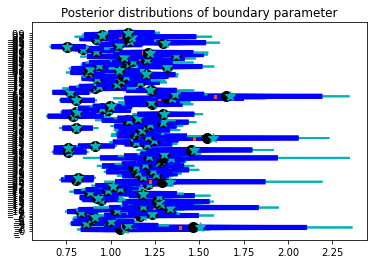

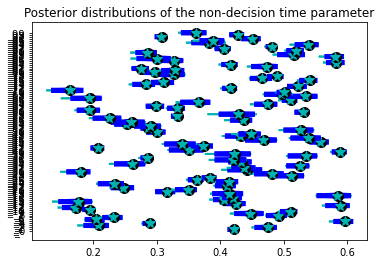

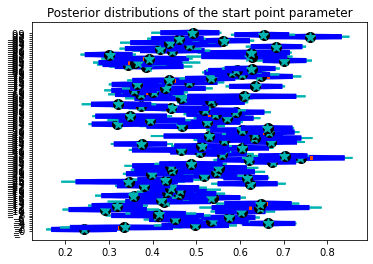

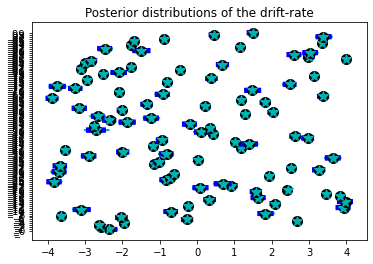

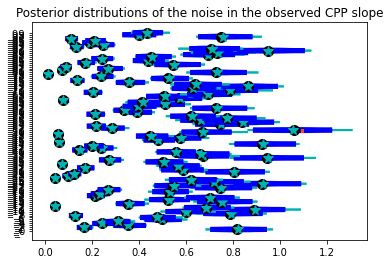

In [41]:
# Posterior distributions
plt.figure()
jellyfish(samples['alpha'])
plt.title('Posterior distributions of boundary parameter')
plt.savefig('figures/alpha_posteriors_simpleCPP.png', format='png', bbox_inches="tight")

plt.figure()
jellyfish(samples['ndt'])
plt.title('Posterior distributions of the non-decision time parameter')
plt.savefig('figures/ndt_posteriors_simpleCPP.png', format='png', bbox_inches="tight")

plt.figure()
jellyfish(samples['beta'])
plt.title('Posterior distributions of the start point parameter')
plt.savefig('figures/beta_posteriors_simpleCPP.png', format='png', bbox_inches="tight")

plt.figure()
jellyfish(samples['delta'])
plt.title('Posterior distributions of the drift-rate')
plt.savefig('figures/delta_posteriors_simpleCPP.png', format='png', bbox_inches="tight")

plt.figure()
jellyfish(samples['CPPnoise'])
plt.title('Posterior distributions of the noise in the observed CPP slope')
plt.savefig('figures/CPPnoise_posteriors_simpleCPP.png', format='png', bbox_inches="tight")


And look at some recovery plots!

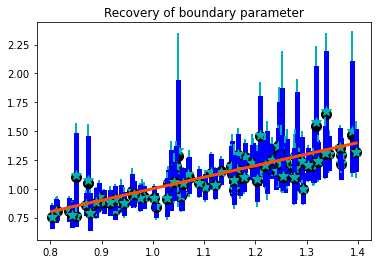

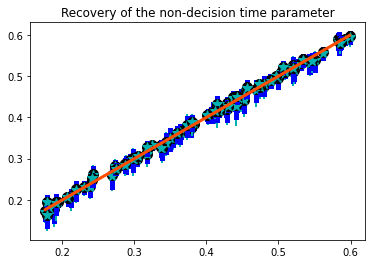

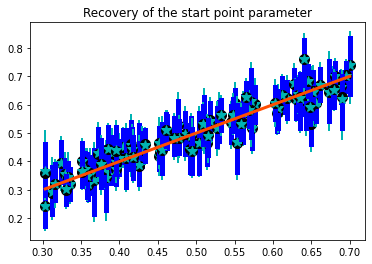

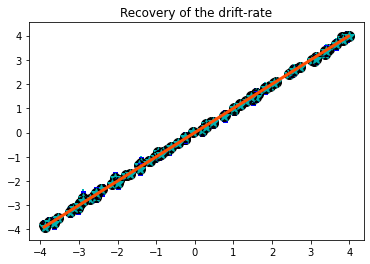

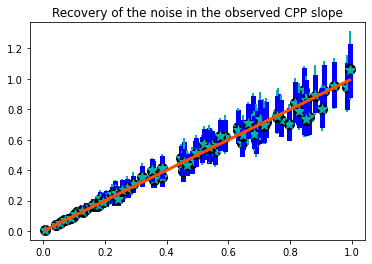

In [42]:


# Recovery
plt.figure()
recovery(samples['alpha'], genparam['alpha'])
plt.title('Recovery of boundary parameter')
plt.savefig('figures/alpha_recovery_simpleCPP.png', format='png', bbox_inches="tight")

plt.figure()
recovery(samples['ndt'], genparam['ndt'])
plt.title('Recovery of the non-decision time parameter')
plt.savefig('figures/ndt_recovery_simpleCPP.png', format='png', bbox_inches="tight")

plt.figure()
recovery(samples['beta'], genparam['beta'])
plt.title('Recovery of the start point parameter')
plt.savefig('figures/beta_recovery_simpleCPP.png', format='png', bbox_inches="tight")

plt.figure()
recovery(samples['delta'], genparam['delta'])
plt.title('Recovery of the drift-rate')
plt.savefig('figures/delta_recovery_simpleCPP.png', format='png', bbox_inches="tight")

plt.figure()
recovery(samples['CPPnoise'], genparam['CPPnoise'])
plt.title('Recovery of the noise in the observed CPP slope')
plt.savefig('figures/CPPnoise_recovery_simpleCPP.png', format='png', bbox_inches="tight")
